<h1 style="color:#1f77b4; text-align:left; font-size:40px;">
    Model Evaluation
</h1>

<h3 style="color:#555; text-align:left;">
    Test with non used data, Evaluation metrics, Overfitting and Model interpretation
</h3>


<h2 style="color:#1f77b4; border-bottom: 3px solid #1f77b4; padding-bottom:4px;">
</h2>

# **1 Libraries, Data, Models Importantion and Auxiliary Functions**
## **1.1 Import Libraries**

In [1]:
# --- System utilities ---
import os
import sys
import json
import joblib
from datetime import datetime

# --- Data manipulation ---
import numpy as np
import pandas as pd

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Scikit-learn base utilities ---
from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
    KFold,
    StratifiedKFold,
    cross_val_score,
    cross_validate,
    GridSearchCV,
    RandomizedSearchCV
)
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import f1_score

# --- Scikit-learn models ---
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# --- XGBoost ---
from xgboost import XGBClassifier

# --- Optuna ---
import optuna
from optuna.trial import TrialState

c:\Users\sergi\O meu disco\NOVA IMS\EDSA\08 - Enterprise Data Science Bootcamp\EnterpriseDataScienceBootcamp_workgroup\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## **1.2 Import Data files**


In [2]:
def load_processed_data(path: str = "../data/processed"):
    """
    Load all processed data and feature selections from the given path.
    """
    data = {}

    # ============================
    # Base data (train/val)
    # ============================
    data["X"] = pd.read_parquet(f"{path}/X.parquet")
    data["X_enc"] = pd.read_parquet(f"{path}/X_enc.parquet")
    data["y"] = pd.read_csv(f"{path}/y.csv")

    # ============================
    # Test data
    # ============================
    data["X_test_final"] = pd.read_parquet(f"{path}/X_test_final.parquet")
    data["X_test_final_enc"] = pd.read_parquet(f"{path}/X_test_final_enc.parquet")
    data["y_test_final"] = pd.read_csv(f"{path}/y_test_final.csv")

    return data

data = load_processed_data()

# ============================
# Base data (train/val)
# ============================
X_train = data["X"]
X_train_enc = data["X_enc"]
y_train = data["y"].squeeze("columns")              # assume só 1 coluna em y.csv


X_test = data["X_test_final"]
X_test_enc = data["X_test_final_enc"]
y_test = data["y_test_final"].squeeze("columns")


## **1.3 Importing models**

In [3]:
import joblib
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Caminho para o alias atual
models_info_path = "../data/processed/6-Optimized_Models_Parameters/current.pkl"
models_info = joblib.load(models_info_path)

# Mapear código de modelo para a classe correta
MODEL_CLASSES = {
    "XGB": XGBClassifier,
    "RF": RandomForestClassifier,
    "LOG": LogisticRegression,
}


In [4]:
# ============================================
# AUXILIAR: Mostrar subsets e features importados do current.pkl
# ============================================

def show_feature_subsets(models_info):
    print("\n========== FEATURE SUBSETS IMPORTADOS ==========\n")

    for model_code, info in models_info.items():
        subset_name = info["subset"]
        features = info["features"]

        print(f" Modelo: {model_code}")
        print(f"   → Subset vencedor: {subset_name}")
        print(f"   → Nº de features: {len(features)}")
        print(f"   → Lista de features:")
        print("      " + ", ".join(features))
        print("\n" + "-"*80 + "\n")


# Chamada da função
show_feature_subsets(models_info)



========== FEATURE SUBSETS IMPORTADOS ==========

 Modelo: LOG
   → Subset vencedor: all_data_enc
   → Nº de features: 25
   → Lista de features:
      demo_age, demo_number_of_dependents, loc_zip_code, svc_number_of_referrals, svc_tenure_in_months, svc_phone_service, svc_avg_monthly_long_distance_charges, svc_multiple_lines, svc_avg_monthly_gb_download, svc_online_security, svc_online_backup, svc_device_protection_plan, svc_premium_tech_support, svc_unlimited_data, svc_paperless_billing, svc_monthly_charge, Is_woman, Has_offer, svc_internet_type_DSL, svc_internet_type_Fiber Optic, svc_internet_type_No Internet, svc_contract_One Year, svc_contract_Two Year, svc_payment_method_Credit Card, svc_payment_method_Mailed Check

--------------------------------------------------------------------------------

 Modelo: RF
   → Subset vencedor: all_data_enc
   → Nº de features: 25
   → Lista de features:
      demo_age, demo_number_of_dependents, loc_zip_code, svc_number_of_referrals, svc_tenur

## **1.4 Auxiliar Functions**

In [5]:
def confirm_columns(df1, df2):
    """
    Print the columns of df1 and df2 side by side, in order.
    Useful to visually confirm if both dataframes are aligned.
    """
    print("Index | df1 column name  | df2 column name")
    print("-------------------------------------------")
    
    for i, (col1, col2) in enumerate(zip(df1.columns, df2.columns)):
        print(f"{i:5d} | {col1:20s} | {col2}")


# **2 Build, Train and Test Models**

In [6]:
from sklearn.metrics import classification_report, confusion_matrix

def train_and_evaluate_model(model_code: str,
                             models_info: dict,
                             X_train,
                             y_train,
                             X_test,
                             y_test):
    """
    Reinstancia o modelo (XGB/RF/LOG) com os mesmos parâmetros,
    TREINA em X_train, y_train,
    e AVALIA em X_test, y_test, usando o subset de features guardado.

    Se alguma feature do subset não existir no DataFrame,
    é ignorada e é emitido um aviso.
    """
    info = models_info[model_code]
    subset_features = info["features"]
    params = info["params"]

    ModelClass = MODEL_CLASSES[model_code]

    # 1) Verificar features em falta
    train_cols = set(X_train.columns)
    test_cols = set(X_test.columns)

    missing_in_train = [f for f in subset_features if f not in train_cols]
    missing_in_test = [f for f in subset_features if f not in test_cols]

    if missing_in_train or missing_in_test:
        print(f"\n⚠️ Atenção: no modelo {model_code}, algumas features do subset não existem no DataFrame:")
        if missing_in_train:
            print(f"   - Em X_train faltam: {missing_in_train}")
        if missing_in_test:
            print(f"   - Em X_test faltam: {missing_in_test}")

    # 2) Usar apenas as features que existem em ambos
    valid_features = [
        f for f in subset_features
        if (f in train_cols) and (f in test_cols)
    ]

    if not valid_features:
        raise ValueError(
            f"Nenhuma das features do subset para o modelo {model_code} "
            f"está presente em X_train/X_test. Verifica o pipeline de encoding."
        )

    # 3) Instanciar modelo com os mesmos hiperparâmetros
    model = ModelClass(**params)

    # 4) Filtrar colunas
    X_train_sub = X_train[valid_features]
    X_test_sub = X_test[valid_features]

    # 5) Treinar nos dados de treino
    print(f"\n✅ Modelo {model_code} será treinado em X_train, y_train "
          f"com {len(valid_features)} features (subset: {info['subset']}).")
    model.fit(X_train_sub, y_train)

    # 6) Previsões no TEST
    y_pred = model.predict(X_test_sub)

    print(f"\n========== Modelo: {model_code} ==========")
    print(f"Subset original tinha {len(subset_features)} features.")
    print(f"Subset efetivo (após compatibilidade train/test): {len(valid_features)} features.")

    print("\nClassification report (TEST):")
    print(classification_report(y_test, y_pred))

    print("Confusion matrix (TEST):")
    print(confusion_matrix(y_test, y_pred))

    return model


# **3 Results with Test Data**

In [7]:
# Garantir que tens estas variáveis definidas:
# X_enc, y, X_test_final, y_test_final
# (vindos do load_processed_data)

final_xgb_test = train_and_evaluate_model(
    "XGB", models_info, X_train_enc, y_train, X_test_enc, y_test
)

final_rf_test = train_and_evaluate_model(
    "RF", models_info, X_train_enc, y_train, X_test_enc, y_test
)

final_log_test = train_and_evaluate_model(
    "LOG", models_info, X_train_enc, y_train, X_test_enc, y_test
)



✅ Modelo XGB será treinado em X_train, y_train com 25 features (subset: all_data_enc).

========== Modelo: XGB ==========
Subset original tinha 25 features.
Subset efetivo (após compatibilidade train/test): 25 features.

Classification report (TEST):
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      1035
           1       0.72      0.73      0.73       374

    accuracy                           0.85      1409
   macro avg       0.81      0.81      0.81      1409
weighted avg       0.85      0.85      0.85      1409

Confusion matrix (TEST):
[[930 105]
 [101 273]]

✅ Modelo RF será treinado em X_train, y_train com 25 features (subset: all_data_enc).

========== Modelo: RF ==========
Subset original tinha 25 features.
Subset efetivo (após compatibilidade train/test): 25 features.

Classification report (TEST):
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      1035
           1  

## **3 ROC Curve**

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve, roc_auc_score,
    precision_recall_curve, average_precision_score,
    classification_report, confusion_matrix,
    f1_score, precision_score, recall_score
)

# Subsets de features para cada modelo (vindos do current.pkl)
X_test_xgb = X_test_enc[models_info["XGB"]["features"]]
X_test_rf  = X_test_enc[models_info["RF"]["features"]]
X_test_log = X_test_enc[models_info["LOG"]["features"]]


In [9]:
def get_roc_data(model, X_test, y_test):
    """
    Devolve FPR, TPR, thresholds e AUC para um modelo.
    """
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_score = model.decision_function(X_test)
    else:
        raise ValueError("Modelo não tem nem predict_proba nem decision_function.")

    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    auc_value = roc_auc_score(y_test, y_score)
    return fpr, tpr, thresholds, auc_value


def get_pr_data(model, X_test, y_test):
    """
    Devolve precision, recall, thresholds e Average Precision (PR AUC).
    """
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_score = model.decision_function(X_test)
    else:
        raise ValueError("Modelo não tem nem predict_proba nem decision_function.")

    precision, recall, thresholds = precision_recall_curve(y_test, y_score)
    ap_value = average_precision_score(y_test, y_score)
    return precision, recall, thresholds, ap_value


In [10]:
# ROC data
fpr_xgb, tpr_xgb, thr_xgb, auc_xgb = get_roc_data(final_xgb_test, X_test_xgb, y_test)
fpr_rf,  tpr_rf,  thr_rf,  auc_rf  = get_roc_data(final_rf_test,  X_test_rf,  y_test)
fpr_log, tpr_log, thr_log, auc_log = get_roc_data(final_log_test, X_test_log, y_test)


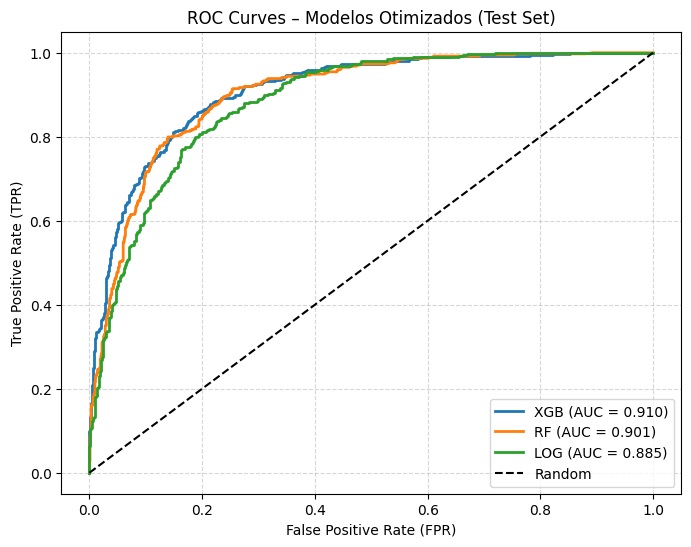

In [11]:
plt.figure(figsize=(8, 6))

plt.plot(fpr_xgb, tpr_xgb, label=f"XGB (AUC = {auc_xgb:.3f})", linewidth=2)
plt.plot(fpr_rf,  tpr_rf,  label=f"RF (AUC = {auc_rf:.3f})", linewidth=2)
plt.plot(fpr_log, tpr_log, label=f"LOG (AUC = {auc_log:.3f})", linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label="Random")

plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curves – Modelos Otimizados (Test Set)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


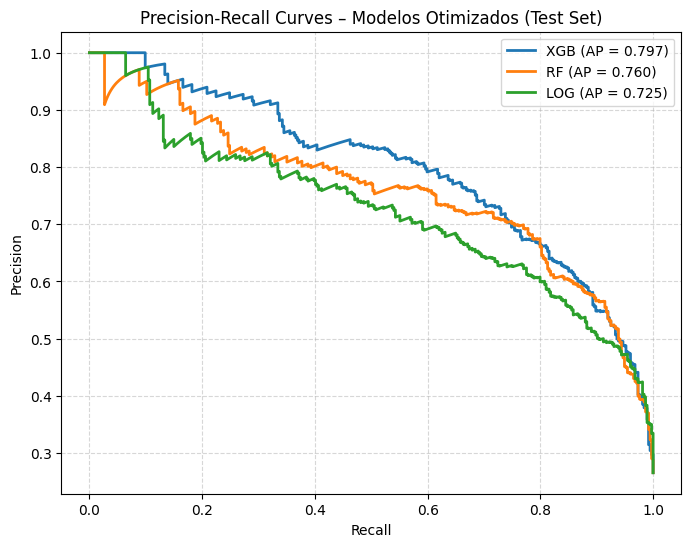

In [12]:
prec_xgb, rec_xgb, thr_pr_xgb, ap_xgb = get_pr_data(final_xgb_test, X_test_xgb, y_test)
prec_rf,  rec_rf,  thr_pr_rf,  ap_rf  = get_pr_data(final_rf_test,  X_test_rf,  y_test)
prec_log, rec_log, thr_pr_log, ap_log = get_pr_data(final_log_test, X_test_log, y_test)

plt.figure(figsize=(8, 6))

plt.plot(rec_xgb, prec_xgb, label=f"XGB (AP = {ap_xgb:.3f})", linewidth=2)
plt.plot(rec_rf,  prec_rf,  label=f"RF (AP = {ap_rf:.3f})", linewidth=2)
plt.plot(rec_log, prec_log, label=f"LOG (AP = {ap_log:.3f})", linewidth=2)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves – Modelos Otimizados (Test Set)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


In [ ]:
import pandas as pd

def get_basic_metrics(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    return {
        "Model": name,
        "F1": f1_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred)
    }

rows = []
rows.append(get_basic_metrics(final_xgb_test, X_test_xgb, y_test, "XGB"))
rows.append(get_basic_metrics(final_rf_test,  X_test_rf,  y_test, "RF"))
rows.append(get_basic_metrics(final_log_test, X_test_log, y_test, "LOG"))

metrics_df = pd.DataFrame(rows)

metrics_df["ROC AUC"] = [auc_xgb, auc_rf, auc_log]
metrics_df["PR AUC"]  = [ap_xgb, ap_rf, ap_log]
metrics_df

metrics_df


,Model,F1,Precision,Recall,ROC AUC,PR AUC
0,XGB,0.726064,0.722222,0.729947,0.909732,0.796962
1,RF,0.672593,0.754153,0.606952,0.901263,0.760196
2,LOG,0.655367,0.694611,0.620321,0.885277,0.724975


In [19]:
from sklearn.metrics import roc_curve

def get_roc_data(model, X_test):
    """
    Devolve FPR, TPR e thresholds.
    Usa predict_proba ou decision_function conforme disponível.
    """
    # Se o modelo tiver predict_proba:
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)[:, 1]

    # Caso seja um modelo que só tenha decision_function (não é o caso aqui)
    elif hasattr(model, "decision_function"):
        y_score = model.decision_function(X_test)

    else:
        raise ValueError("Modelo não tem nem predict_proba nem decision_function.")

    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    return fpr, tpr, thresholds


